### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# Densenet

*Author: Pytorch Team*

**Dense Convolutional Network (DenseNet), connects each layer to every other layer in a feed-forward fashion.**

_ | _
- | -
![alt](https://pytorch.org/assets/images/densenet1.png) | ![alt](https://pytorch.org/assets/images/densenet2.png)

In [2]:
import torch
import numpy as np
import io, os, sys, types
sys.path.append(os.path.abspath("prat_density_net.py"))
%load_ext autoreload
%autoreload 2
%aimport prat_density_net
from prat_density_net import *
model = densenet201()
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(3 x H x W)`, where `H` and `W` are expected to be at least `224`.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

Here's a sample execution.

In [4]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [11]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
print(torch.nn.functional.softmax(output[0], dim=0))


torch.Size([1, 1, 28, 28])
torch.Size([1, 512, 28, 28])
641
771
tensor([[0.8512]], device='cuda:0')
tensor([[1.]], device='cuda:0')


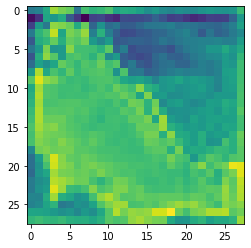

In [12]:
import matplotlib.pyplot as plt
im = output[3].detach().cpu()
im.shape
plt.imshow(im[0][0])

In [7]:
# initialize tensor a and do some dummy operations
a = torch.tensor(2.4, requires_grad=True)
b = a * 7
c = 4 * b ** 2
c.retain_grad()  # I want to use a gradient with respect to this variable

# more dummy operations
d = 2 * torch.log(c) * a
e = d ** 1.2

# backpropagating to get the intermediate grad
#e.backward(retain_graph=True)
f = c.grad  # I got the gradient I wanted f = de/dc
print(f)

g = e  # using the f in more dummy calculation

# Finally backpropagating to get dg/da
torch.autograd.backward(g,c)
print(a.grad)
g

None
tensor(49449.2461)


tensor(68.1971, grad_fn=<PowBackward0>)

In [8]:
torch.autograd.backward(g)

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

### Model Description

Dense Convolutional Network (DenseNet), connects each layer to every other layer in a feed-forward fashion. Whereas traditional convolutional networks with L layers have L connections - one between each layer and its subsequent layer - our network has L(L+1)/2 direct connections. For each layer, the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers. DenseNets have several compelling advantages: they alleviate the vanishing-gradient problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters.

The 1-crop error rates on the imagenet dataset with the pretrained model are listed below.

| Model structure | Top-1 error | Top-5 error |
| --------------- | ----------- | ----------- |
|  densenet121        | 25.35       | 7.83        |
|  densenet169        | 24.00       | 7.00        |
|  densenet201        | 22.80       | 6.43        |
|  densenet161        | 22.35       | 6.20        |

### References

 - [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993).

In [ ]:
def image_split_random_no_padd(image,annotation,s):
    """
    Takes an image and the annotation, returns a random small patch of s*s size
    """
    h,w = image.shape
    # a revoir, mettre le zero padding
    xr = np.random.rand()
    yr = np.random.rand()
    x = (s/2)+xr*(h-s)
    y = (s/2)+yr*(w-s)
    
    return image[x-s/2:x+s/2;y-s/2:y+s/2],annotation[x-s/2:x+s/2;y-s/2:y+s/2]
    

In [ ]:
def image_split_random(image,annotation,s):
    """
    Takes an image and the annotation, returns a random small patch of s*s size
    """
    h,w = image.shape
    # a revoir, mettre le zero padding
    
    xr = np.random.rand()
    yr = np.random.rand()
    x = (s/2)+xr*(h-s)
    y = (s/2)+yr*(w-s)
    
    return image[x-s/2:x+s/2;y-s/2:y+s/2],annotation[x-s/2:x+s/2;y-s/2:y+s/2]

In [9]:
def image_crop(image,annotation,p_size):
    w,h = image.size()
    print(800/224)
    print(np.ceil(800/224))
    new_x = int(np.ceil(h/p_size)*p_size)
    print("x padding = "+str(new_x - w))
    return new_x

In [15]:
t= np.array([[1,2,3,4],[5,6,7,8]])
t.flatten()

array([1, 2, 3, 4, 5, 6, 7, 8])

In [8]:
print(800/224)
print(np.ceil(800/224))
new_x = int(np.ceil(800/224)*224)
print("x padding = "+str(new_x - w))
new_x

3.5714285714285716
4.0
x padding = 96


896

In [6]:
h=600
w=800
s=224
xr = np.random.rand()
yr = np.random.rand()
x = (s/2)+xr*(h-s)
y = (s/2)+yr*(w-s)
print(int(x))
print(int(y))
print(yr)


353
130
0.03281263499939502


In [10]:
a = [[1, 2, 3, 4, 5],[1, 2, 3, 4, 5]]
np.pad(a, (0, 1), 'linear_ramp',end_values=(0,))

array([[1, 2, 3, 4, 5, 0],
       [1, 2, 3, 4, 5, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
np.pad(a, [(0, 1), (0, 0)], mode='constant', constant_values=0)

In [35]:
a = np.array([[[1, 2, 3, 4, 5],[1, 2, 3, 4, 5],[1, 2, 3, 4, 5]],[[1, 2, 3, 4, 5],[1, 2, 3, 4, 5],[1, 2, 3, 4, 5]]])
print(a.shape)
np.pad(a, [(0,0),(0, 1), (0, 0)], mode='constant', constant_values=0)

(2, 3, 5)


array([[[1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5],
        [0, 0, 0, 0, 0]],

       [[1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5],
        [0, 0, 0, 0, 0]]])

In [34]:
len(a)

2

In [ ]:
class DensenetDataset(Dataset):
    """
    Densenet dataset
    """
    